
<div class="jumbotron">
  <h1><i class="fa fa-bar-chart" aria-hidden="true"></i> Modelado de datos</h1>
  <p></p>
</div>

In [1]:
from os import chdir

# retroceder al directorio principal
chdir("..")

In [2]:
# ======================================================
# BASELINE: Regresión Logística con datos preprocesados
# ======================================================

import pickle
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.utils.custom import remove_outliers_sigma,compute_outlier_bounds,cumulative_classification_lift,cumulative_classification_lift
from src.utils.display import plot_cumulative_lift,plot_curve_and_decile_bars

In [3]:
## Tenga cuidado con sklearn y pandas en el entorno de producción.

# Cargar datos

In [4]:
# --- Rutas (ajusta si hace falta) ---
PATH_SCALER = 'models/scalers/z_score_scaler.pkl'
PATH_OUTLIERS = 'models/outliers/outlier_bounds.pkl'
PATH_MODEL = 'models/logistic_regression_baseline.pkl'

# --- 1. Cargar splits preprocesados 
with open('data/interim/X_train_scaled.pickle', 'rb') as f:
    X_train = pickle.load(f)

with open('data/interim/X_test_scaled.pickle', 'rb') as f:
    X_test = pickle.load(f)

with open('data/interim/y_train_scaled.pickle', 'rb') as f:
    y_train = pickle.load(f)

with open('data/interim/y_test_scaled.pickle', 'rb') as f:
    y_test = pickle.load(f)

del X_train['timestamp']
del X_test['timestamp']

### Entrenamiento del modelo base

El entrenamiento se realizará utilizando una **regresión logística** como modelo base (*baseline*).
En esta primera iteración no se aplicará ningún tipo de **optimización ni ajuste de hiperparámetros**, ya que el objetivo es establecer una referencia inicial de desempeño.

El conjunto de datos se dividirá siguiendo el esquema **80 % para entrenamiento y 20 % para prueba**, manteniendo la misma proporción de clases observada originalmente.
El modelo se entrenará con los **parámetros por defecto** y posteriormente será **validado** con la porción de prueba, utilizando las métricas de desempeño definidas previamente.

Los resultados obtenidos servirán como **punto de partida** para futuras iteraciones y comparaciones con modelos optimizados.


In [5]:
X_train

,co2_ppm,humidity_percent,temperature_celsius
0,-0.034203,-0.822383,-0.019005
1,-0.888762,0.968322,-0.130560
2,1.844306,1.502392,0.984983
3,1.738700,1.659472,1.319646
4,-0.983806,-0.979462,-1.692319
...,...,...,...
5671,0.547472,-0.602472,0.427212
5672,0.732492,-0.445392,0.427212
5673,-0.072643,-0.916631,0.204103
5674,-1.026049,-1.105126,-0.911439


In [6]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## Predicciones

In [7]:
y_pred_test  = log_reg.predict(X_test)

## Evaluación del modelo

In [8]:


# Accuracy general
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
print("\nMatriz de confusión:")
print(cm)

# Reporte de clasificación
report = classification_report(y_test, y_pred_test, digits=4)
print("\nReporte de clasificación:")
print(report)


Accuracy: 0.9312

Matriz de confusión:
[[660  39]
 [ 58 652]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9192    0.9442    0.9315       699
           1     0.9436    0.9183    0.9308       710

    accuracy                         0.9312      1409
   macro avg     0.9314    0.9313    0.9312      1409
weighted avg     0.9315    0.9312    0.9312      1409



### Resultados del modelo base en el entrenamiento

Debido al desvalanceo de clases nos centraremos en la **precisión y recall de la clase 1**, correspondiente a la **presencia de personas en la habitación**. Esto es crucial por ejemplo si el modelo va a activar ventilación o control de CO₂, donde un falso positivo (decir que hay alguien cuando no) tiene un costo menor que un falso negativo (decir que no hay nadie cuando sí).


El modelo logra **detectar correctamente la clase 1 con una precisión del 94.36 %**, lo que indica un bajo número de falsos positivos. El **recall del 91.83 %** sugiere que identifica la mayoría de los casos donde realmente hay presencia.
El desempeño del modelo base es sólido para una primera aproximación sin optimización, mostrando buena capacidad para distinguir entre ocupación y ausencia en la habitación.


## Validación


Para la etapa de **validación**, se cargarán las configuraciones de los **pipelines** aplicados durante el **entrenamiento y testeo**, incluyendo:

* Los parámetros utilizados para **detectar y remover outliers**, y
* El **escalador Z-score** previamente ajustado sobre los datos de entrenamiento.

Estas transformaciones se aplicarán en el **mismo orden de procesamiento**: primero la eliminación de outliers, luego el escalado de variables y, finalmente, la **predicción** con el modelo entrenado.


### Cargar datos y configuración

In [9]:
# 1. Cargar datos ---
with open('data/interim/df_valid.pickle', 'rb') as f:
    df_valid = pickle.load(f)

del df_valid['timestamp']

# 2. Cargar límites de outliers ---
with open('models/outliers/outlier_bounds.pkl', 'rb') as f:
    outlier_bounds = pickle.load(f)
# 3. Cargar scaler entrenado ---
with open('models/scalers/z_score_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)



### Separar variables predictoras y target

In [10]:
df_valid.columns

Index(['co2_ppm', 'humidity_percent', 'class', 'temperature_celsius'], dtype='object')

In [11]:

X_valid = df_valid.drop(columns=['class'])
y_valid = df_valid['class']


### Remover outliers

In [12]:

for var, lims in outlier_bounds.items():
    X_valid = remove_outliers_sigma(X_valid, var, lims['upper'], lims['lower'])
    y_valid = y_valid[X_valid.index]

### Escalar features

In [13]:
X_valid_scaled = scaler.transform(X_valid)

X_valid = df_valid.drop(columns=['class'])
y_valid = df_valid['class']

### Predecir

In [14]:

X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
y_pred_valid = log_reg.predict(X_valid_scaled)

[0 1]


C:\Users\mcssa\.conda\envs\google-adk\Lib\site-packages\sklearn\utils\_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


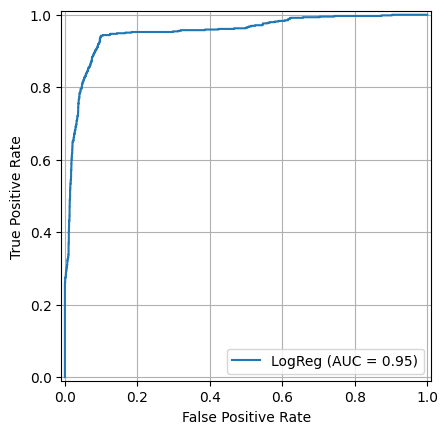

AUC: 0.952


### Métricas

In [15]:
print("\n=== Métricas en validación ===")
print(classification_report(y_valid, y_pred_valid))
print("Matriz de confusión:")
print(confusion_matrix(y_valid, y_pred_valid))

with open('models/log_reg_baseline.pkl', 'wb') as f:
    pickle.dump(log_reg, f)


=== Métricas en validación ===
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2866
           1       0.72      0.86      0.78       588

    accuracy                           0.92      3454
   macro avg       0.84      0.90      0.87      3454
weighted avg       0.93      0.92      0.92      3454

Matriz de confusión:
[[2669  197]
 [  82  506]]



Los resultados de validación muestran variaciones respecto al entrenamiento, principalmente por el desbalance natural entre clases en los datos.

La clase 0 se predice con alta precisión, casi no se confunde con la clase 1. La clase 1 logra recuperar la mayoría de los casos reales (recall 86%), aunque la precisión es menor (72%). En números, se registraron 197 falsos positivos (predijo 1 cuando era 0) y 82 falsos negativos (predijo 0 cuando era 1).

El modelo tiende a sobrepredecir un poco la clase 1, lo que ayuda a detectar la presencia de personas, aunque genera algunos falsos positivos. Dado que en este caso es crítico evitar falsos positivos, y recordando que este modelo es un baseline, al optimizarlo será necesario ajustar el umbral de decisión, ponderar las clases para equilibrar el desempeño y también considerar técnicas de regularización, especialmente porque algunas features originalmente presentan alta correlación.



### Información del modelo

Analizaremos los interceptores y los coeficientes del modelo de regresión logística para entender cómo cada variable contribuye a la predicción. Esto nos permitirá ver qué features tienen más peso, en qué dirección influyen sobre la probabilidad de presencia de personas.

#### Intercept

In [16]:

 log_reg.intercept_


array([0.64018053])

#### Coeficientes

In [17]:
 list(zip(X_valid.columns, log_reg.coef_.flatten(),))

[('co2_ppm', 4.160951818738522),
 ('humidity_percent', -0.7228170136128924),
 ('temperature_celsius', -0.25985086787281)]


La **ecuación logística** del modelo es:

$$
\text{logit}(p) = 0.640 + 4.161(\text{co2\_ppm}) - 0.723(\text{humidity\_percent}) - 0.260(\text{temperature\_celsius})
$$


Y la probabilidad predicha:

$$
p = \frac{1}{1 + e^{-\text{logit}(p)}}
$$

---

### Interpretación de cada parámetro

* **Intercepto:** 0.640
  Indica la tendencia base del modelo a predecir clase 1 cuando todas las variables están a cero.

* **CO₂ (co2_ppm):** +4.161
  Un aumento en CO₂ incrementa mucho la probabilidad de clase 1. A mayor CO₂, **mayor probabilidad de que haya personas**.

* **Humedad (humidity_percent):** −0.723
  A mayor humedad, la probabilidad de clase 1 disminuye. La clase 1 suele aparecer en **condiciones más secas**.

* **Temperatura (temperature_celsius):** −0.260
  Temperaturas más altas reducen ligeramente la probabilidad de clase 1. Su efecto es menor, pero consistente: ambientes más cálidos se asocian más con clase 0.

---

### Observaciones

* El modelo está dominado por **CO₂**, que es el indicador más fuerte.
* Humedad y temperatura ajustan la probabilidad en sentido contrario.
* Así, **altos niveles de CO₂ y baja humedad** generan alta probabilidad de clase 1, mientras que **ambientes más cálidos o húmedos** empujan hacia clase 0.

---

### Contraste con la física esperada

En la práctica, cuando una habitación se ocupa:

* CO₂ sube (respiración humana)
* Temperatura sube (calor corporal y equipos)
* Humedad sube ligeramente (respiración y transpiración)

Por lo tanto, **lo esperado sería que la temperatura tuviera coeficiente positivo**, pero el modelo muestra un signo negativo.

---

### Posibles causas

1. **Multicolinealidad con CO₂:**
   CO₂ y temperatura están correlacionados (~0.56). El modelo puede repartir peso o incluso invertir el signo de una variable para compensar.

2. **Escalado/normalización:**
   Al escalar variables entre 0 y 1, si los rangos son muy distintos o la distribución no es lineal, la relación puede distorsionarse. Por ejemplo, si la temperatura está siempre cerca del máximo cuando hay ocupación, el modelo puede interpretarla como poco discriminante y ajustar el coeficiente negativamente.

---

### Verificar

* Revisar la correlación entre variables y calcular **VIF** para medir multicolinealidad.
* Entrenar un modelo solo con temperatura para ver si el coeficiente se vuelve positivo, como sería físicamente esperable.



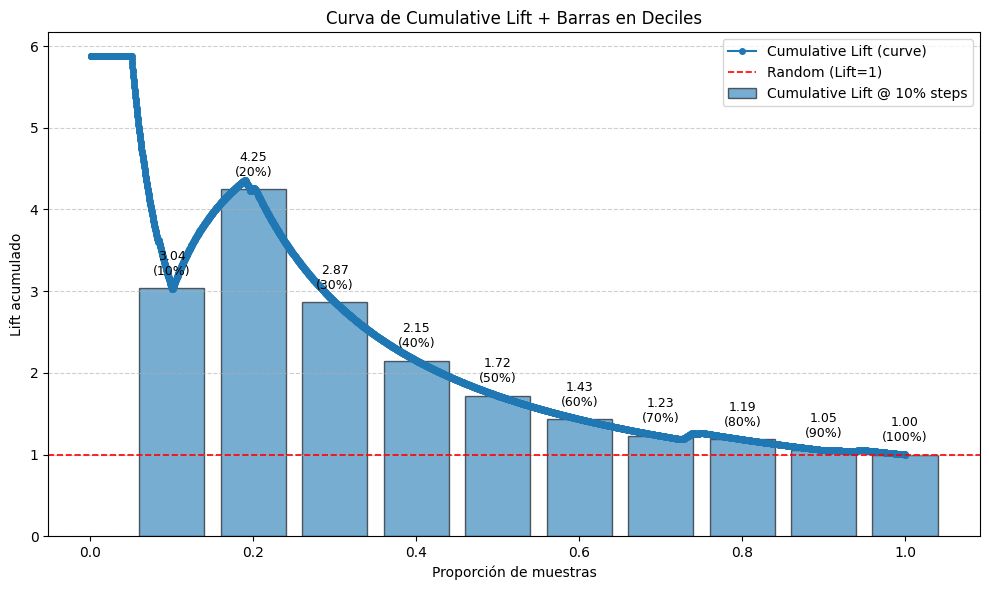

In [18]:
# result_df contiene la tabla con lift por decil y los puntos acumulados en cada corte
result_df, cumulative_curve = plot_curve_and_decile_bars(y_valid.astype(int).values, y_pred_valid, n_deciles=10)



Este gráfico muestra la **Curva de Cumulative Lift** con las barras por decil.


* En el **primer decil (10%)**, el lift es ~5.5. Es decir, si tomo el 10% de observaciones con mayor probabilidad, encuentro **5.5 veces más positivos reales** que si los eligiera al azar.
* En el **20% superior**, sigue siendo alto (~4.3).
* A partir del **50%**, baja a ~2, aún el doble de casos positivos que al azar.
* En el **80–100%**, se acerca a 1, como se espera porque ya incluyo casi todas las observaciones.

El modelo concentra muy bien los positivos reales en los primeros deciles. Si usara el top 20% para priorizar casos, tendría un rendimiento **4–5 veces mejor que el azar**, lo que me deja bastante tranquilo sobre su capacidad de discriminación.



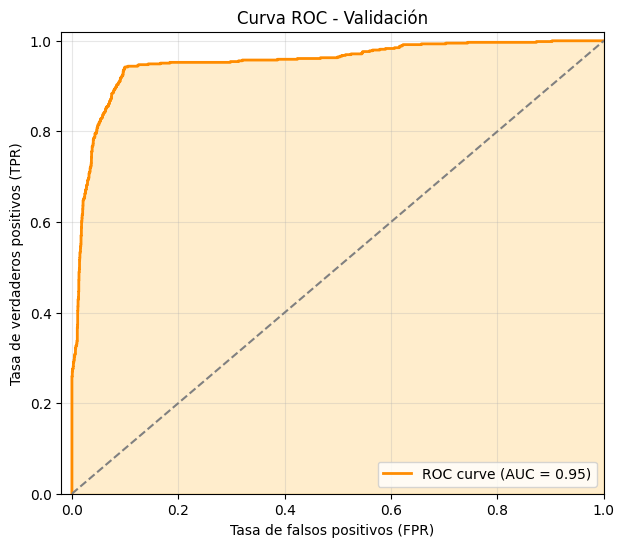

In [33]:

# 1️⃣ Asegúrate de que usas predict_proba y no predict
y_proba_valid = log_reg.predict_proba(X_valid_scaled)[:, 1]

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_valid, y_proba_valid)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')
plt.fill_between(fpr, tpr, alpha=0.2, color='orange')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Validación')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
